In [1]:
import tensorflow as tf

from tensorflow.keras import layers, models, callbacks, saving
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

2024-05-20 12:19:36.320013: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 12:19:36.352208: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 12:19:36.864680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# export CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
# export LD_LIBRARY_PATH=${CUDNN_PATH}/lib
tf.config.list_physical_devices('GPU')

2024-05-20 12:19:39.148464: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 12:19:39.300085: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 12:19:39.300248: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def run_train(split_number: int, epochs=100):
    NUM_CLASSES = 5

    model = models.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(64, 64, 3)))
    model.add(layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((4, 4)))
    model.add(layers.Conv2D(256, (4, 4), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(NUM_CLASSES))
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.summary()

    train_ds = tf.keras.utils.image_dataset_from_directory(
      f"SPLIT_{split_number}/training",
      batch_size=16,
      image_size=(64, 64),
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
      f"SPLIT_{split_number}/validation",
      batch_size=16,
      image_size=(64, 64),
    )
    AUTOTUNE = tf.data.AUTOTUNE
    
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    checkpoint = callbacks.ModelCheckpoint(
        filepath=f'MODEL{split_number}.keras', 
        verbose=1, 
        monitor='val_accuracy',
        save_best_only=True, 
        mode='max'
    )

    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      callbacks=[checkpoint]
    )

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(6, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.savefig(f'Accuracy_{split_number}.png')
    plt.show()
    
    plt.figure(figsize=(6, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(f'Loss_{split_number}.png')
    plt.show()

    return model, history

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 124, 124, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,314,693 (20.27 MB)

 Trainable params: 5,314,693 (20.27 MB)

 Non-trainable params: 0 (0.00 B)

Found 16181 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Epoch 1/50


I0000 00:00:1716168544.804076  164745 service.cc:145] XLA service 0x7f2df8003600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716168544.804102  164745 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-05-20 03:29:04.826457: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-20 03:29:04.933953: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  19/1012 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2668 - loss: 1.6193

I0000 00:00:1716168546.997820  164745 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 984/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4785 - loss: 1.2715

I0000 00:00:1716168557.109679  164744 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 68 bytes spill stores, 68 bytes spill loads



1009/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4813 - loss: 1.2660
Epoch 1: val_accuracy improved from -inf to 0.72000, saving model to MODEL1.keras
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.4818 - loss: 1.2651 - val_accuracy: 0.7200 - val_loss: 0.8090
Epoch 2/50
1009/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7210 - loss: 0.7466
Epoch 2: val_accuracy improved from 0.72000 to 0.77200, saving model to MODEL1.keras
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7211 - loss: 0.7465 - val_accuracy: 0.7720 - val_loss: 0.7263
Epoch 3/50
1007/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7838 - loss: 0.5918
Epoch 3: val_accuracy improved from 0.77200 to 0.80400, saving model to MODEL1.keras
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7838 - loss: 0.5918 - val_accuracy: 0.8040 - val_loss: 0.6322
Epoch 4/50
1009/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8226 - loss: 0.4843
Epoch 4: val_accuracy did not improve from 0.80

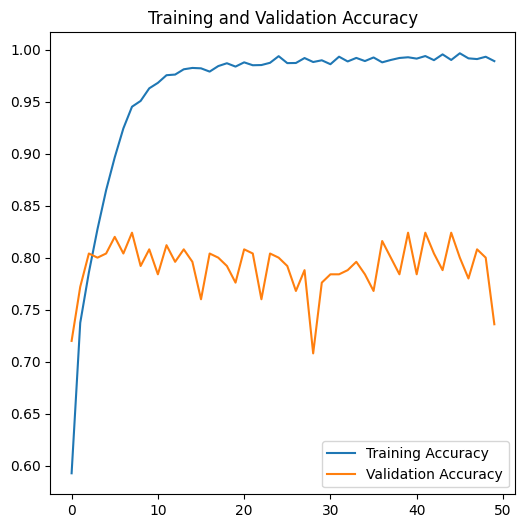

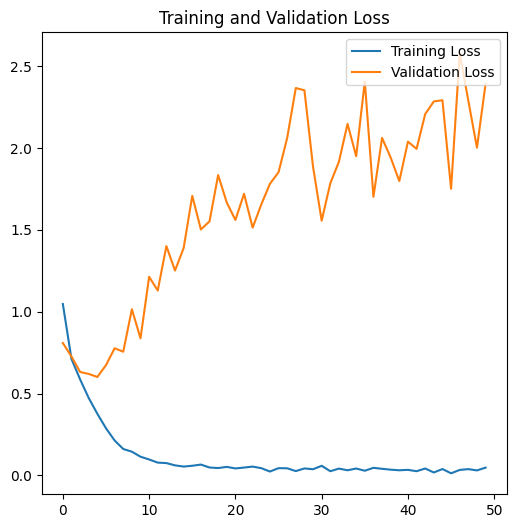

In [6]:
model1, history1 = run_train(1, epochs=50)

/home/szym/repos/SzUM/lab2/venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-05-20 12:19:48.502302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 12:19:48.502466: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,120,389 (4.27 MB)

 Trainable params: 1,120,389 (4.27 MB)

 Non-trainable params: 0 (0.00 B)

Found 49999 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Epoch 1/50


I0000 00:00:1716200391.486791    8391 service.cc:145] XLA service 0x7f02b4016860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716200391.486816    8391 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-05-20 12:19:51.521675: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-20 12:19:51.673957: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  73/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.2022 - loss: 1.6139

I0000 00:00:1716200393.736124    8391 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3107/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4841 - loss: 1.2208
Epoch 1: val_accuracy improved from -inf to 0.81200, saving model to MODEL2.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.4848 - loss: 1.2195 - val_accuracy: 0.8120 - val_loss: 0.6246
Epoch 2/50
3115/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7204 - loss: 0.7463
Epoch 2: val_accuracy improved from 0.81200 to 0.82000, saving model to MODEL2.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7204 - loss: 0.7462 - val_accuracy: 0.8200 - val_loss: 0.4951
Epoch 3/50
3115/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7733 - loss: 0.6169
Epoch 3: val_accuracy improved from 0.82000 to 0.83600, saving model to MODEL2.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7733 - loss: 0.6168 - val_accuracy: 0.8360 - val_loss: 0.4679
Epoch 4/50
3109/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7996 - loss: 0.5416
Epoch 4: val_accuracy improved from 0.83600 to 0.

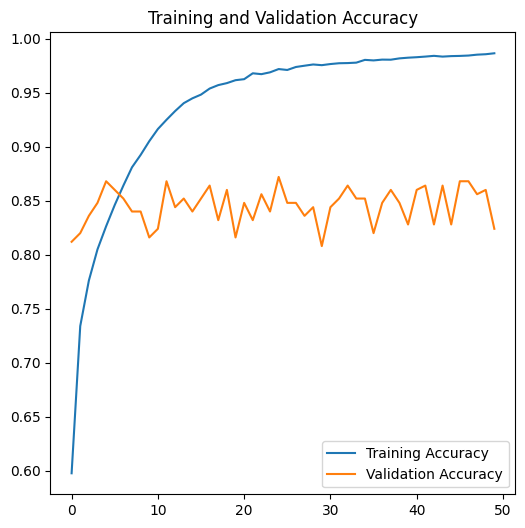

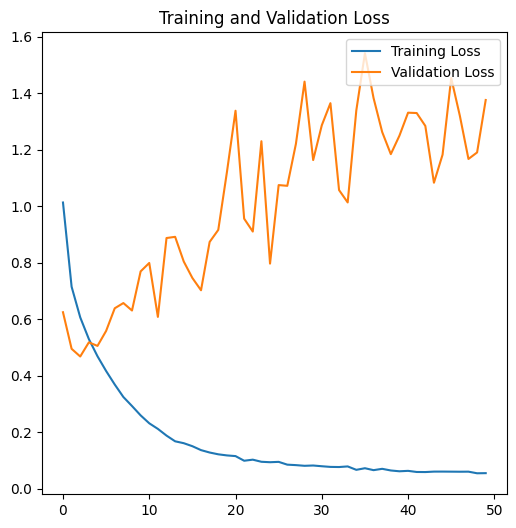

In [4]:
model2, history2 = run_train(2, epochs=50)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 124, 124, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,314,693 (20.27 MB)

 Trainable params: 5,314,693 (20.27 MB)

 Non-trainable params: 0 (0.00 B)

Found 50249 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Epoch 1/50
3138/3141 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5357 - loss: 1.1148
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to MODEL3.keras
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.5359 - loss: 1.1145 - val_accuracy: 0.8000 - val_loss: 0.5982
Epoch 2/50
3137/3141 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7947 - loss: 0.5578
Epoch 2: val_accuracy improved from 0.80000 to 0.87200, saving model to MODEL3.keras
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.7948 - loss: 0.5577 - val_accuracy: 0.8720 - val_loss: 0.3582
Epoch 3/50
3139/3141 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8758 - loss: 0.3520
Epoch 3: val_accuracy improved from 0.87200 to 0.91200, saving model to MODEL3.keras
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.8758 - loss: 0.3520 - val_accuracy: 0.9120 - val_loss: 0.2597
Epoch 4/50
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 

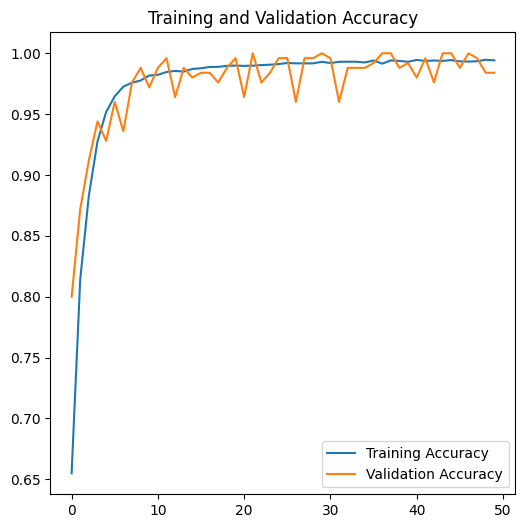

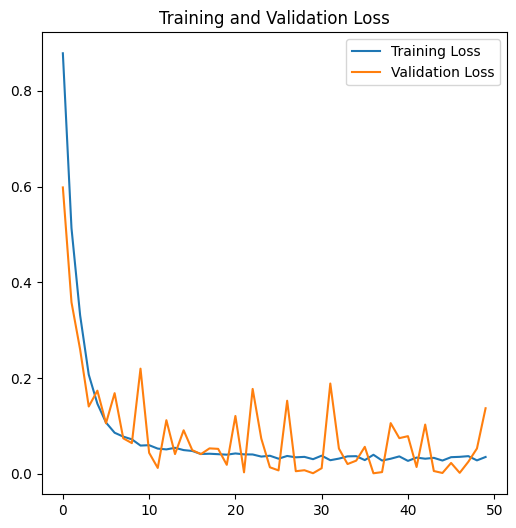

In [8]:
model3, history3 = run_train(3, epochs=50)

In [11]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    f"SPLIT_1/testing",
    image_size=(64, 64),
    batch_size=32
)

Found 250 files belonging to 5 classes.


In [12]:
model1 = saving.load_model("MODEL1.keras")

accuracy = model1.evaluate(test_ds, verbose=0)[1]
print(round(accuracy, 3))

0.844


In [13]:
model2 = saving.load_model("MODEL2.keras")

accuracy = model2.evaluate(test_ds, verbose=0)[1]
print(round(accuracy, 3))

0.84


In [14]:
model3 = saving.load_model("MODEL3.keras")

accuracy = model3.evaluate(test_ds, verbose=0)[1]
print(round(accuracy, 3))

0.844
